# AE4441-16 Practical Assignment - J.J. Knobbout (4303385)

(This notebook is best viewed in full-screen)

The taxi-planning concept described in the paper $\textit{Optimal Airport Surface Traffic Planning Using Mixed-Integer Linear Programming}$ by P. Roling (from here on referred to as 'the paper') uses Mixed Integer Linear Programming to develop a tool that is able to provide a taxi planning schedule for arriving/departing aircraft. The tool is demonstrated with the use of a hypothetical airport and a complex aircraft arrival/departure schedule that presents conflicts when all aircraft would follow their individually optimal route.

The airport is drawn below.

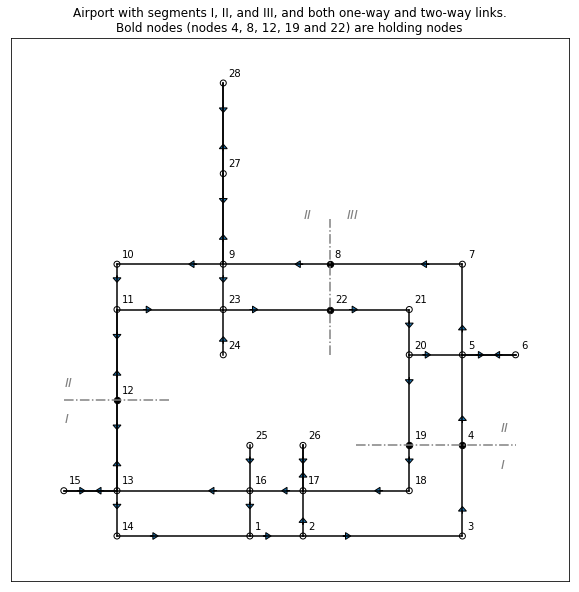

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from functions import drawAirport
from airportData import nodes, links

# 'nodes' is a dictionary with node indices as key and their [x,y] position as value.
# 'links' is a dictionary with link start and end incides as key (e.g. "1601" is link 16-1) and [length,segment] as value.

plt.figure(figsize = (10,10));
    
drawAirport(nodes, links)

plt.title("Airport with segments I, II, and III, and both one-way and two-way links.\n"+\
          "Bold nodes (nodes 4, 8, 12, 19 and 22) are holding nodes");
plt.show()

The schedule contains 8 aircraft, 6 departing and 2 arriving: 

In [2]:
import pandas as pd
from airportData import schedule

# schedule is an array of aircraft with 
# [T_start, T_end, speed, node_start, node_end] as rows:

print(schedule)

[['01:10' '06:00' '8' '26' '15']
 ['01:00' '07:00' '16' '24' '15']
 ['01:40' '07:00' '16' '25' '6']
 ['01:20' '07:30' '8' '25' '6']
 ['02:40' '08:30' '16' '25' '6']
 ['02:20' '08:30' '8' '24' '6']
 ['00:00' '09:30' '8' '28' '26']
 ['00:30' '09:00' '8' '28' '26']]


Determining the optimal route of individual aircraft is simply a matter of solving an LP problem that minimizes the total distance. The approach is described in $\textit{Introduction to Operations Research}$, 10th edition, by F. Hillier, from page 377 onwards. Here it is included in functions.py as getOptimisedRoute(nodes, links, aircraft). This will return the optimal route in string form, for example: "2617-1716-1613-1315", along with the total distance. However, to allow aircraft to be rerouted, an alternative route needs to be determined as well. This is done by first determining the optimal route and then removing the second-to-last link of the optimal route from the total set of links in the airport, forcing the algorithm to find a new route. In the example "2617-1716-1613-1315", link "1613" would be removed and a new route will be calculated without this link. This will result in an array of 2 routes for every aircraft, which is created below.

In [3]:
from functions import getOptimisedRoute

routes = []

for aircraft in schedule:

    # First determine optimal route
    [opt_route, opt_distance] = getOptimisedRoute(nodes,links,aircraft)
    
    # Find the second to last link of the optimal route
    route_links = opt_route.split("-")
    nlinks = len(route_links)
    removed_link = route_links[nlinks-2]
    
    # Create a new dictionary of airport links without the second to last link
    new_links = {}
    for link in links:
        if link != removed_link:
            new_links[link] = links[link]
    
    # Determine alternative route
    [alt_route, alt_distance] = getOptimisedRoute(nodes, new_links, aircraft)
    
    routes.append([[opt_route, opt_distance], [alt_route, alt_distance]])
    

The resulting routes are shown below:

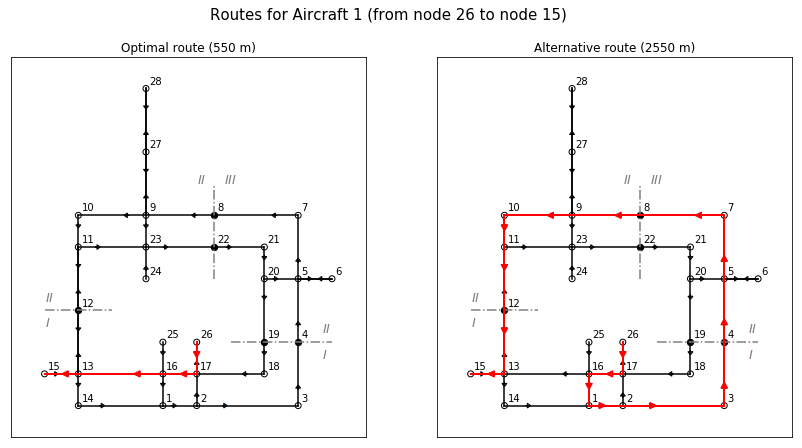

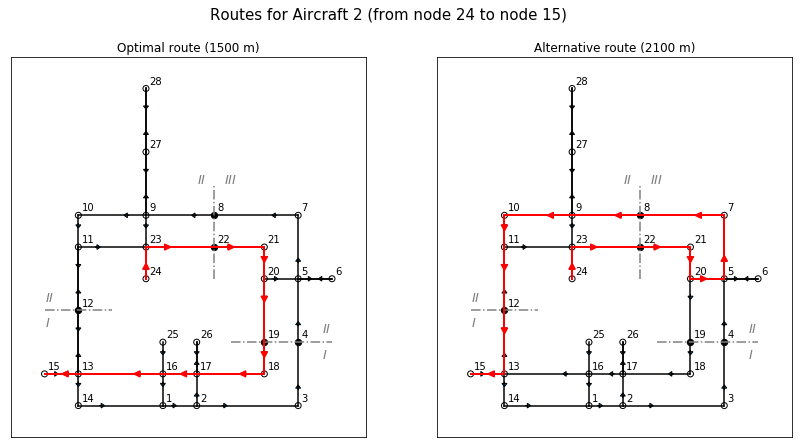

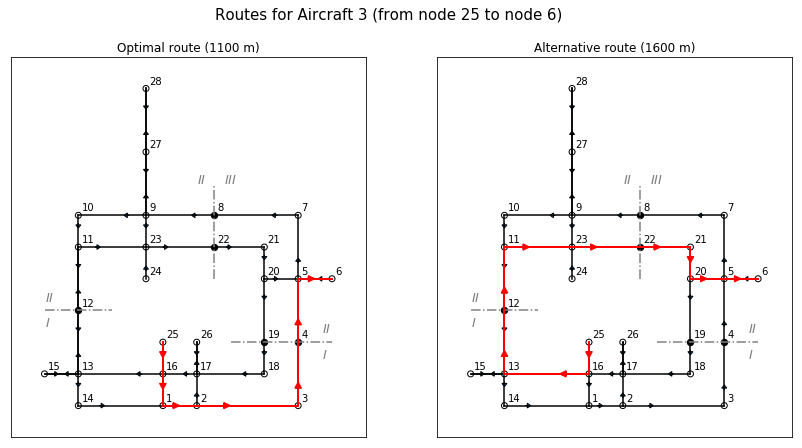

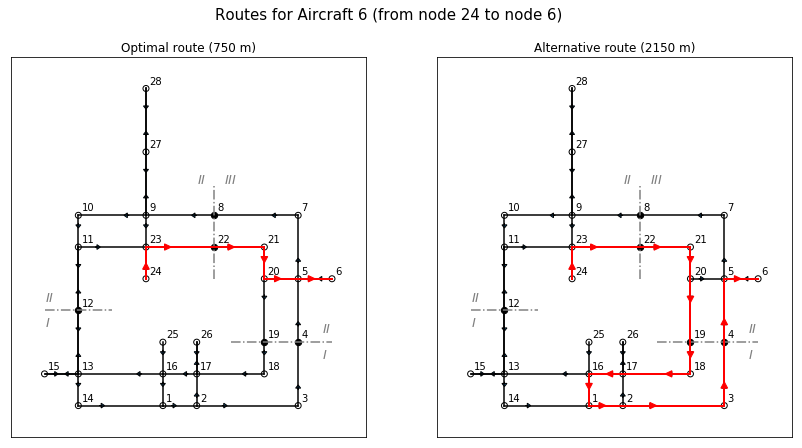

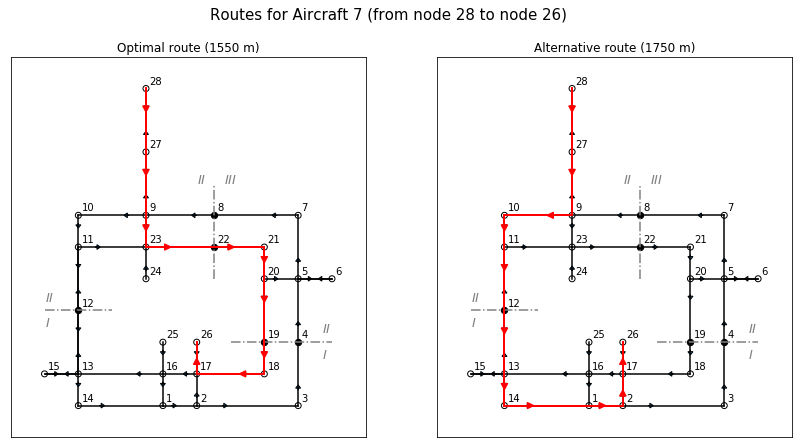

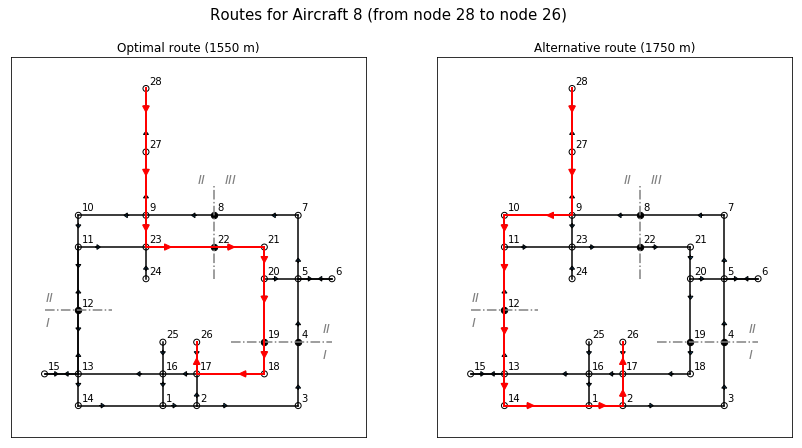

In [4]:
from functions import drawRoute

# Draw all routes
i = 1
for f in routes:
    # skip aircraft 4 and 5 as these routes are the same as aircraft 3:
    if i != 4 and i != 5:
        
        plt.figure(figsize = (14, 7));
        plt.suptitle("Routes for Aircraft "+str(i)+" (from node "+str(schedule[i-1][3])+" to node "+str(schedule[i-1][4])+")",
                                                                                             fontsize = 15);

        plt.subplot(121);
        plt.title("Optimal route ("+str(int(f[0][1]))+" m)");
        drawAirport(nodes,links)
        drawRoute(nodes,links,f[0])
        
        plt.subplot(122);
        plt.title("Alternative route ("+str(int(f[1][1]))+" m)");
        drawAirport(nodes,links)
        drawRoute(nodes,links,f[1])
    i+=1

If every aircraft were to follow its optimal route at their respective starting times, conflicts would arise. A MILP problem is defined to resolve these conflicts. 

### Decision variables

The decision variables are the following binary variables:

$x_{f,d,r,s}$ These variables are true if the states $d$, $r$, and $s$ are true for a flight $f$.

$w_{f,d,r,s}$ These variables are true if a flight $f$ with states $d$, $r$, and $s$ has to wait for one period.

These are programmed as follows:



In [5]:
import pulp as plp # Linear programming package for Python

# Define LP problem
prob = plp.LpProblem(sense=plp.LpMinimize)

d_max = 120 # Set total maximum delay [s]
horizon = 420 # Set planning horizon [s]
period = 10 # Set period length [s]

n_horizon = int(horizon/period) # Discretised horizon
n_d_max = int(d_max/period) # Discretised maximum delay 

# There are 8 flights, so:
f_max = len(schedule) # = 8

# To determine s_max, we need an array of the number of segments per route, per flight:
from functions import createSegmentArray
segments = createSegmentArray(links, routes)

# Create empty dicts for decision variables:
x_vars = {}
w_vars = {}
for f in range(1,f_max+1): # Flight indices start at 1
    r_max = len(routes[f-1]) # Get number of routes per flight
    s_max = max(segments[f-1]) # Get maximum number of segments per flight
    for r in range(1,r_max+1): # Route indices start at 1
        for s in range(1,s_max+1): # Segment indices start at 1
            for n_d in range(0,n_d_max+1): # Delay indices start at 0
                # Delays in periods converted back to delays in seconds
                d = n_d*period
                
                # Creating decision variables
                x_vars[f,d,r,s] = plp.LpVariable("x_"+str(f)+"_"+str(d)+"_"+str(r)+"_"+str(s), cat=plp.LpBinary)
                w_vars[f,d,r,s] = plp.LpVariable("w_"+str(f)+"_"+str(d)+"_"+str(r)+"_"+str(s), cat=plp.LpBinary)

print("Resulting in a total of "+str(len(x_vars)+len(w_vars))+" decision variables")

Resulting in a total of 1404 decision variables


### Objective function

The objective function Z minimises the total taxi time and the total holding time:

$Z =\sum_{f=1}^{f_{max}}\sum_{r=1}^{r_{max(f)}}\sum_{d=0}^{d_{max}}K_f \left[C_r + C_d\right]x_{f,d,r,s_{max(f,r)}}$

$s_{max}$ here depends on $f$ and $r$, so this is different per route per flight.

Here, $K_f$ is the flight priority cost factor. A higher value for $K_f$ for a given flight makes delaying that flight more expensive than other flights.

$C_r$ is the route time cost multiplied by the total active taxi time (without delay):

$C_r = K_r(T_{start(f,r)} - T_{end(f,r))}$

Here, $K_r$ is the user-specified route time cost factor, $T_{start(f,r)}$ is the time on which route (r) of flight (f) starts and $T_{start(f,r)}$ when it ends.

Finally, the delay cost factor $C_d$ is defined as:

$C_d = K_dd$

This is programmed as follows:

In [6]:
# Create coefficients for objective function
coeffs = {}

# Set Kf value for every flight:
Kf = [1, 1, 1, 1, 1, 1, 1, 1]

# Set global cost factors
Kr = 1
Kd = 5

for f in range(1,f_max+1): # Aircraft indices starts at 1
    speed = int(schedule[f-1][2])
    
    r_max = len(routes[f-1][0])
    for r in range(1,r_max+1): # Route indices start at 1
        
        s_max = segments[f-1][r-1] # Get number of segments per route
        # Not iterating through s, using s_max instead
        
        for n_d in range(0,n_d_max+1): # Delay indices start at 0
            d = n_d * period

            # T_start - T_end is simply the length it takes for flight f to complete route r

            length = routes[f-1][r-1][1]

            duration = length / speed

            Cr = Kr * duration

            Cd = Kd * d

            coeffs[f,d,r,s_max] = Kf[f-1] * (Cr + Cd)

# Create and add objective function to the problem
prob += plp.lpSum(x_vars[f,d,r,s] * coeffs[f,d,r,s] for f,d,r,s in coeffs)

### Constraints

#### Route And Delay Choice
This forces a route and delay to be chosen for every flight and segment:

$RADC_{f,s} \text{ : } \sum_{r=1}^{r_{max(f)}}\sum_{d=0}^{d_{max(f,r,s)}}x_{f,d,r,s}=1$

where $f$ ranges from 1 to $f_{max}$ and $s$ ranges from 1 to $s_{max(f)}$. 

Contrary to the objective function, $s_{max}$ now only depends on $f$ (see $s_{max(f)}$), so the maximum number of segments between the 2 routes for every flight is taken instead of the maximum number of segments per individual route.

Also $d_{max}$ depends on $f$, $r$, and $s$ now, so <span style="color:red">I'm assuming this means that $d_{max(f,r,s)} = 120 \text{ (total delay) } / s$ to get the maximum delay per segment for every individual route and segment.</span>

All this is programmed as follows:

In [7]:
for f in range(1, f_max+1):
    s_max = max(segments[f-1])
    r_max = len(routes[f-1])
    for s in range(1, s_max+1):
        tempvars = {}
        for r in range(1, r_max+1): 
            for n_d in range(0,int(n_d_max/s)+1):
                d = n_d * period
                tempvars[f,d,r,s] = "x_"+str(f)+"_"+str(d)+"_"+str(r)+"_"+str(s)
        
        # Add constraint to problem for every f, s:
        prob += plp.lpSum(x_vars[f,d,r,s] for f,d,r,s in tempvars) == 1, "RADC_"+str(f)+"_"+str(s)

The RADC constraint for flight 1, segment 1, for example, is then:

In [8]:
print("RADC_1_1:",prob.constraints["RADC_1_1"])

RADC_1_1: x_1_0_1_1 + x_1_0_2_1 + x_1_100_1_1 + x_1_100_2_1 + x_1_10_1_1 + x_1_10_2_1 + x_1_110_1_1 + x_1_110_2_1 + x_1_120_1_1 + x_1_120_2_1 + x_1_20_1_1 + x_1_20_2_1 + x_1_30_1_1 + x_1_30_2_1 + x_1_40_1_1 + x_1_40_2_1 + x_1_50_1_1 + x_1_50_2_1 + x_1_60_1_1 + x_1_60_2_1 + x_1_70_1_1 + x_1_70_2_1 + x_1_80_1_1 + x_1_80_2_1 + x_1_90_1_1 + x_1_90_2_1 = 1


#### Waiting Times
A sequence and flow conservation constraint that ties all segments and waiting periods together:

$WT_{f,r,s} \text{ : } \sum_{d=0}^{d_{max(f,r,s)}}2^{\frac{d}{\Delta t}}x_{f,d,r,s}-2^{\frac{d}{\Delta t}}x_{f,d,r,s-1}-2^{\frac{d}{\Delta t}}w_{f,d,r,s}=0$

where $f$ ranges from 1 to $f_{tot}$ <span style="color:red">((I'm not sure what the difference is between 'tot' and 'max', I'll assume they're the same)</span>, $r$ ranges from 1 to $r_{tot(f)}$, and $s$ ranges from 2 to $s_{tot(f,r)}$.

These are programmed as follows:

In [9]:
for f in range(1, f_max+1):
    r_max = len(routes[f-1])
    
    for r in range(1, r_max+1):
        s_max = segments[f-1][r-1]
        
        for s in range(2, s_max+1):
            tempvars = {}

            for n_d in range(0,int(n_d_max/s)+1):
                #Store the function for every value of d
                d = n_d*period
                tempvars[f,d,r,s] = "x_"+str(f)+"_"+str(d)+"_"+str(r)+"_"+str(s)
            
            prob += plp.lpSum(x_vars[f,d,r,s]*2**(d/period)
                              -x_vars[f,d,r,s-1]*2**(d/period)
                              -w_vars[f,d,r,s]*2**(d/period) 
                              for f,d,r,s in tempvars) == 0, "WT_"+str(f)+"_"+str(r)+"_"+str(s)

The WT constraint for flight 1, route 2, and segment 3, for example, is then:

In [10]:
print("WT_1_2_3:",prob.constraints["WT_1_2_3"])

WT_1_2_3: -w_1_0_2_3 - 2.0*w_1_10_2_3 - 4.0*w_1_20_2_3 - 8.0*w_1_30_2_3 - 16.0*w_1_40_2_3 - x_1_0_2_2 + x_1_0_2_3 - 2.0*x_1_10_2_2 + 2.0*x_1_10_2_3 - 4.0*x_1_20_2_2 + 4.0*x_1_20_2_3 - 8.0*x_1_30_2_2 + 8.0*x_1_30_2_3 - 16.0*x_1_40_2_2 + 16.0*x_1_40_2_3 = -0.0


#### Node and Link Occupancy
Node occupany is a holding constraint to avoid conflicts:

$NO_{t,n} \text{ : } \sum_{f=1}^{f_{max}}\sum_{r=1}^{r_{max(f)}}\sum_{s=0}^{s_{max(f,r)}}\sum_{d=1}^{d_{max(f,r,s)}}n_{f,r,s,n,t-d}-x_{f,d,r,s}\leq 1$

Link occupany is a separation constraint to avoid conflicts as well:

$LO_{t,l} \text{ : } \sum_{f=1}^{f_{max}}\sum_{r=1}^{r_{max(f)}}\sum_{s=0}^{s_{max(f,r)}}\sum_{d=1}^{d_{max(f,r,s)}}l_{f,r,s,n,t-d}-x_{f,d,r,s}\leq 1$

For both constraints, $t$ ranges from $t_{min}$ (earliest starting time) to $t_{max}$ (latest time to arrive at destination). This differs per flight, so the iteration over $t$ is contained within the $f$ loop.

<span style="color:red">((I don't know how to determine the $n$ and $l$ binary constants. Should I simulate each aircraft travelling both of their respective routes and then find out which link/node they occupy at which time intervals t?

In [11]:
from functions import getTimeInPeriods

for f in range(1, f_max+1):

    t_min = getTimeInPeriods(schedule[f-1][0], period)
    t_max = getTimeInPeriods(schedule[f-1][1], period)
    
    for t in range(t_min, t_max+1):
        ...?


SyntaxError: invalid syntax (<ipython-input-11-52bfabef6635>, line 9)